# 🦷 Detection of Tilted Errors in Bitewing Radiograph using  CNNs for Quality Assurance




In [ ]:
!rm -rf output

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name() 

'/device:GPU:0'

## 🎛️ Setting up Preliminaries

import libraries and packages

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from PIL import Image
from glob import glob
from google.colab.patches import cv2_imshow

get data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Bitewing Radiographs Data/Bitewing Radiographs Data.zip"

Archive:  /content/gdrive/MyDrive/Bitewing Radiographs Data/Bitewing Radiographs Data.zip
   creating: Bitewing Radiographs Data/normal/
  inflating: Bitewing Radiographs Data/normal/okay (1).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (10).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (100).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1000).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1001).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1002).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1003).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1004).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1005).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1006).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1007).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1008).jpg  
  inflating: Bitewing Radiographs Data/normal/okay (1009).jpg  
  inflating: Bitewing Radiographs Dat

## 🛠️ Data Pre-Processing



user-defined functions

In [ ]:
def is_grey_scale(img_path):
  
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

In [ ]:
def undersample_2class(df, columnName):

    label_list = list(df[columnName].unique())
    classA = label_list[0]
    classB = label_list[1]

    classA_len = len(df.loc[df[columnName] == classA])
    classB_len = len(df.loc[df[columnName] == classB])

    if classA_len > classB_len:
        n_discard = classA_len - classB_len
        start = list(df.loc[df[columnName]==classA].index)[0]
        end = list(df.loc[df[columnName]==classA].index)[-1]
    elif classA_len < classB_len:
        n_discard = classB_len - classA_len
        start = list(df.loc[df[columnName]==classB].index)[0]
        end = list(df.loc[df[columnName]==classB].index)[-1]
    else:
        return df

    random.seed(123)
    index_list = random.sample(range(start,end), n_discard)

    for index in index_list:
        df.drop(index, inplace=True)

    df.reset_index(inplace=True)
    
    return df

In [ ]:
def find_largestdimIMG(folderdir):

  imgA_path = folderdir + "/" + os.listdir(folderdir)[0]
  imgA = cv2.imread(imgA_path, cv2.IMREAD_UNCHANGED)

  for file in glob(folderdir+'/*'):
    imgA_dim = imgA.shape[0]*imgA.shape[1]

    imgB_path = file
    imgB = cv2.imread(imgB_path, cv2.IMREAD_UNCHANGED)
    imgB_dim = imgB.shape[0]*imgB.shape[1]

    if imgB_dim >= imgA_dim:
      imgA = imgB
      imgA_path = file

  return imgA_path

In [ ]:
def find_lowestdimIMG(folderdir):

  imgA_path = folderdir + "/" + os.listdir(folderdir)[0]
  imgA = cv2.imread(imgA_path, cv2.IMREAD_UNCHANGED)

  for file in glob(folderdir+'/*'):
    imgA_dim = imgA.shape[0]*imgA.shape[1]

    imgB_path = file
    imgB = cv2.imread(imgB_path, cv2.IMREAD_UNCHANGED)
    imgB_dim = imgB.shape[0]*imgB.shape[1]

    if imgB_dim <= imgA_dim:
      imgA = imgB
      imgA_path = file

  return imgA_path

In [ ]:
NORMAL_PATH = "/content/output/train/normal"
TILTED_PATH = "/content/output/train/tilted"

check whether image is in grayscale or rgb

In [ ]:
#for file in glob(NORMAL_PATH+'/*'):
#    img_name = file # path
#    if is_grey_scale(img_name) == False:
#      print("Image is in RGB")
#      print(img_name)

#for file in glob(TILTED_PATH+'/*'):
#    img_name = file # path
#    if is_grey_scale(img_name) == False:
#      print("Image is in RGB")
#      print(img_name)

7 images are in rgb channels due to external labelling. Those images will be deleted from the dataset to not complicate the model  progress of learning

In [ ]:
!rm -rf "/content/Bitewing Radiographs Data/normal/okay (1515).jpg"
!rm -rf "/content/Bitewing Radiographs Data/normal/okay (1744).jpg"
!rm -rf "/content/Bitewing Radiographs Data/normal/okay (1199).jpg"
!rm -rf "/content/Bitewing Radiographs Data/normal/okay (467).jpg"

!rm -rf "/content/Bitewing Radiographs Data/tilted/tilted (818).jpg"
!rm -rf "/content/Bitewing Radiographs Data/tilted/tilted (580).jpg"
!rm -rf "/content/Bitewing Radiographs Data/tilted/tilted (812).jpg"

identify the biggest and smallest image (in pixel) from each class for visualization purpose

In [ ]:
#largestNormal_img = find_largestdimIMG(NORMAL_PATH)
#smallestNormal_img = find_lowestdimIMG(NORMAL_PATH)
#largestTilted_img = find_largestdimIMG(TILTED_PATH)
#smallestTilted_img = find_lowestdimIMG(TILTED_PATH)

#print(largestNormal_img)
#print(smallestNormal_img)
#print(largestNormal_img)
#print(smallestNormal_img)

a list of path of biggest and smallest image

In [ ]:
#/content/Bitewing Radiographs Data/normal/okay (2476).jpg
#/content/Bitewing Radiographs Data/normal/okay (1692).jpg
#/content/Bitewing Radiographs Data/normal/okay (2476).jpg
#/content/Bitewing Radiographs Data/normal/okay (1692).jpg

split folder into train(training set, validation set) and test set.

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
data_folder = "/content/Bitewing Radiographs Data"

In [ ]:
splitfolders.ratio(data_folder, output="output", seed=7, ratio=(0.9, 0, 0.1))

Copying files: 4750 files [00:01, 2998.93 files/s]


test set consists of 475 radiograph. train/validation set consist of 4275 radiographs.

In [ ]:
test_path = "/content/output/test"
test_path_NORMAL_PATH = "/content/output/test/normal"
test_path_TILTED_PATH = "/content/output/test/tilted"

In [ ]:
x = [] 
y = [] 

for file in glob(test_path_NORMAL_PATH+'/*'):
    img_name = file # path
    x.append(img_name)
    y.append(test_path_NORMAL_PATH.split("/")[-1])

for file in glob(test_path_TILTED_PATH+'/*'):
    img_name = file # path
    x.append(img_name)
    y.append(test_path_TILTED_PATH.split("/")[-1])
        
testdf = pd.DataFrame({'image': x,'type': y})

In [ ]:
testdf

,image,type
0,/content/output/test/normal/okay (1228).jpg,normal
1,/content/output/test/normal/okay (2749).jpg,normal
2,/content/output/test/normal/okay (3026).jpg,normal
3,/content/output/test/normal/okay (1462).jpg,normal
4,/content/output/test/normal/okay (1285).jpg,normal
...,...,...
471,/content/output/test/tilted/tilted (562).jpg,tilted
472,/content/output/test/tilted/tilted (1301).jpg,tilted
473,/content/output/test/tilted/tilted (682).jpg,tilted
474,/content/output/test/tilted/tilted (1665).jpg,tilted


manual oversampling ; vertical and horizontal flipping on tilted radiograph

In [ ]:
for file in glob(TILTED_PATH+'/*'):
    img = cv2.imread(file)
    img_f = cv2.flip(img, 1)

    filename = file.split("/")[-1].replace('.jpg', '')
    filename = TILTED_PATH + '/' + filename + "_hf.jpg"

    cv2.imwrite(filename, img_f)

In [ ]:
for file in glob(TILTED_PATH+'/*'):
    img = cv2.imread(file)
    img_f = cv2.flip(img, 0)

    filename = file.split("/")[-1].replace('.jpg', '')
    filename = TILTED_PATH + '/' + filename + "_vf.jpg"

    cv2.imwrite(filename, img_f)

manual oversampling ; horizontal flipping on normal radiograph

In [ ]:
for file in glob(NORMAL_PATH+'/*'):
    img = cv2.imread(file)
    img_f = cv2.flip(img, 1)

    filename = file.split("/")[-1].replace('.jpg', '')
    filename = NORMAL_PATH + '/' + filename + "_vf.jpg"

    cv2.imwrite(filename, img_f)

In [ ]:
x = [] 
y = [] 

for file in glob(NORMAL_PATH+'/*'):
    img_name = file # path
    x.append(img_name)
    y.append(NORMAL_PATH.split("/")[-1])

for file in glob(TILTED_PATH+'/*'):
    img_name = file # path
    x.append(img_name)
    y.append(TILTED_PATH.split("/")[-1])
        
df = pd.DataFrame({'image': x,'type': y})

In [ ]:
df

,image,type
0,/content/output/train/normal/okay (740).jpg,normal
1,/content/output/train/normal/okay (2439).jpg,normal
2,/content/output/train/normal/okay (1827).jpg,normal
3,/content/output/train/normal/okay (2873).jpg,normal
4,/content/output/train/normal/okay (2058).jpg,normal
...,...,...
11557,/content/output/train/tilted/tilted (888)_hf_v...,tilted
11558,/content/output/train/tilted/tilted (429)_vf.jpg,tilted
11559,/content/output/train/tilted/tilted (1561)_hf_...,tilted
11560,/content/output/train/tilted/tilted (398)_hf.jpg,tilted


detecting blurry images as they can be noise.

In [ ]:
# images = np.array([cv2.imread(i) for i in df['image']], dtype=object)

In [ ]:
# df['value'] = images.tolist()

In [ ]:
# blurimage_index = []

In [ ]:
# for i in range(len(df)):
#  image = df['value'][i]
#  text = df['image'][i]
#  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#  fm = cv2.Laplacian(gray, cv2.CV_64F).var()
#  if fm < 100:
#    blurimage_index.append(i)
#    #print(text, " ", fm)

In [ ]:
# df.drop(df.index[blurimage_index], inplace=True)

In [ ]:
# df.reset_index(drop=True, inplace=True)

In [ ]:
# df

undersample major class (normal), to balance the dataset. It is assume no crucial information is discarded. Sufficient data is needed to feed the CNNs.

In [ ]:
#df = undersample_2class(df, "type")

In [ ]:
#df.drop(['index'], axis=1, inplace=True)

In [ ]:
len(df.loc[df['type']=="tilted"])

6028

In [ ]:
len(df.loc[df['type']=="normal"])

5534

In [ ]:
len(df)

11562

undersample test data

In [ ]:
testdf = undersample_2class(testdf, "type")

In [ ]:
testdf.drop(['index'], axis=1, inplace=True)

In [ ]:
len(testdf.loc[testdf['type']=="tilted"])

168

In [ ]:
len(testdf.loc[testdf['type']=="normal"])

168

In [ ]:
len(testdf)

336

In [ ]:
testdf

,image,type
0,/content/output/test/normal/okay (2749).jpg,normal
1,/content/output/test/normal/okay (1376).jpg,normal
2,/content/output/test/normal/okay (2463).jpg,normal
3,/content/output/test/normal/okay (601).jpg,normal
4,/content/output/test/normal/okay (92).jpg,normal
...,...,...
331,/content/output/test/tilted/tilted (562).jpg,tilted
332,/content/output/test/tilted/tilted (1301).jpg,tilted
333,/content/output/test/tilted/tilted (682).jpg,tilted
334,/content/output/test/tilted/tilted (1665).jpg,tilted


manual shuffling on test set

In [ ]:
testdf = testdf.sample(frac=1).reset_index(drop=True)

In [ ]:
testdf

,image,type
0,/content/output/test/tilted/tilted (1528).jpg,tilted
1,/content/output/test/normal/okay (2254).jpg,normal
2,/content/output/test/tilted/tilted (774).jpg,tilted
3,/content/output/test/tilted/tilted (743).jpg,tilted
4,/content/output/test/tilted/tilted (839).jpg,tilted
...,...,...
331,/content/output/test/normal/okay (748).jpg,normal
332,/content/output/test/normal/okay (1596).jpg,normal
333,/content/output/test/tilted/tilted (1304).jpg,tilted
334,/content/output/test/tilted/tilted (1147).jpg,tilted


## ⚙️ Model Training


In [ ]:
import tensorflow as tf
import keras
from keras import applications, callbacks, datasets, layers, models, optimizers, activations, initializers, regularizers
from keras import backend as K
from keras.layers import *
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,AveragePooling2D,MaxPooling2D,concatenate, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.initializers import glorot_uniform, Constant
from keras.optimizers import gradient_descent_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

model constants

In [ ]:
EPOCHS = 100
IMAGE_H = 224
IMAGE_L = 224
CHANNEL = 1
CLASSES = 2 # normal and tilted

optimizer setting

In [ ]:
# opt = gradient_descent_v2.SGD(learning_rate=0.001, momentum=0.9, decay=0.001/EPOCHS)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9) # 0.001 # 0.084935

stratified k-fold configuration

In [ ]:
skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state=5)

setting up data generator

In [ ]:
train_y = df.type
train_x = df.image

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255 ) #, vertical_flip=True, brightness_range=[1.0,2.0])

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_set = test_datagen.flow_from_dataframe(
    dataframe = testdf, 
    x_col="image",
    y_col="type",
    target_size= (IMAGE_H,IMAGE_L),
    batch_size = 64,
    color_mode= "grayscale", 
    class_mode= 'categorical', 
    shuffle=False, 
    seed=None)

Found 336 validated image filenames belonging to 2 classes.


computing class weight due to imbalanced class

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight( class_weight = "balanced", classes = np.unique(train_y), y = train_y)
class_weights = dict(zip([0,1], class_weights))
class_weights

{0: 1.0446331767256958, 1: 0.9590245520902455}

In [ ]:
# cnn = tf.keras.models.load_model('/content/cnn_model.h5')

### **Base CNN**

In [ ]:
def decay(epoch, steps=100):
    initial_lrate = 0.001
    drop = 0.96
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
def get_model_cnn(classes, input_shape =()):
  
    X_input = Input(input_shape)
    
    X = Conv2D(64, (2, 2), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = Conv2D(128, (2, 2), strides = (1, 1), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = Conv2D(256, (3, 3), strides = (1, 1), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = Conv2D(512, (3, 3), strides = (1, 1), name = 'conv4', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = Conv2D(512, (3, 3), strides = (1, 1), name = 'conv5', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = Flatten()(X)
    X = Dense(1024, activation='relu', kernel_regularizer = regularizers.l2(0.01))(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='tanh', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='CNN')

    model.compile(optimizer=opt, loss='squared_hinge', metrics=['accuracy'], run_eagerly=True)

    return model

callbacks utilities

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", patience = 20, restore_best_weights = True)

lr_sc = LearningRateScheduler(decay, verbose=1)

**flow_from_dataframe object**</br>
training_set ; object</br>
training_set.labels ; label by 0 or 1</br>
training_set.filenames ; picture's directory

Found 9249 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 140s 925ms/step - loss: 9.1626 - accuracy: 0.6493 - val_loss: 3.4564 - val_accuracy: 0.7609
Epoch 2/100
145/145 [==============================] - 136s 940ms/step - loss: 1.9368 - accuracy: 0.8185 - val_loss: 1.3259 - val_accuracy: 0.8418
Epoch 3/100
145/145 [==============================] - 136s 938ms/step - loss: 0.9732 - accuracy: 0.8486 - val_loss: 0.9522 - val_accuracy: 0.8353
Epoch 4/100
145/145 [==============================] - 136s 937ms/step - loss: 0.7076 - accuracy: 0.8709 - val_loss: 0.7489 - val_accuracy: 0.8677
Epoch 5/100
145/145 [==============================] - 135s 932ms/step - loss: 0.5818 - accuracy: 0.8843 - val_loss: 0.6670 - val_accuracy: 0.8638
Epoch 6/100
145/145 [==============================] - 135s 930ms/step - loss: 0.5141 - accuracy: 0.8922 - val_loss: 0.6102 - val_accuracy: 0.8

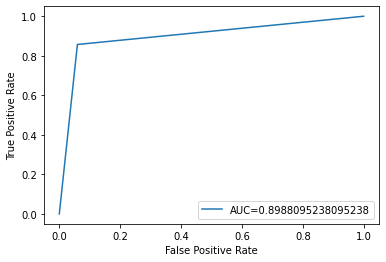

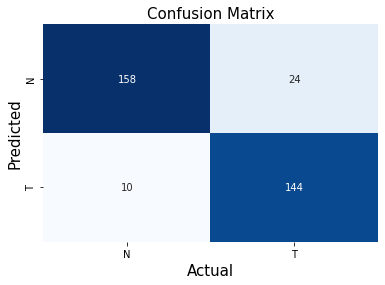

End of epoch  1 




 
Found 9249 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 132s 912ms/step - loss: 2.4994 - accuracy: 0.6677 - val_loss: 0.7571 - val_accuracy: 0.7972
Epoch 2/100
145/145 [==============================] - 133s 915ms/step - loss: 0.6116 - accuracy: 0.8194 - val_loss: 0.6360 - val_accuracy: 0.8487
Epoch 3/100
145/145 [==============================] - 133s 915ms/step - loss: 0.4883 - accuracy: 0.8667 - val_loss: 0.5719 - val_accuracy: 0.8565
Epoch 4/100
145/145 [==============================] - 133s 913ms/step - loss: 0.4450 - accuracy: 0.8778 - val_loss: 0.5415 - val_accuracy: 0.8638
Epoch 5/100
145/145 [==============================] - 133s 916ms/step - loss: 0.4049 - accuracy: 0.8917 - val_loss: 0.5124 - val_accuracy: 0.8815
Epoch 6/100
145/145 [==============================] - 133s 916ms/step - loss: 0.3778 - accuracy: 0.9010 - val_loss: 0.5

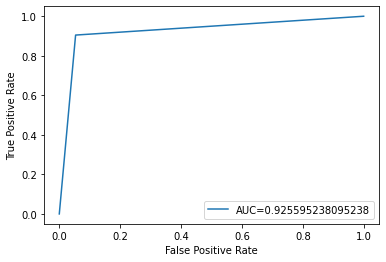

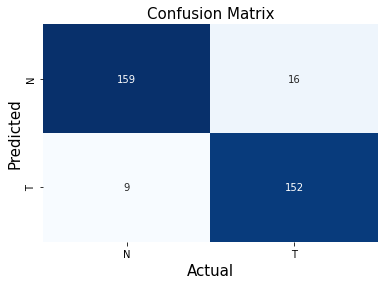

End of epoch  2 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 133s 916ms/step - loss: 2.5641 - accuracy: 0.5522 - val_loss: 0.9178 - val_accuracy: 0.6756
Epoch 2/100
145/145 [==============================] - 131s 903ms/step - loss: 0.7096 - accuracy: 0.7680 - val_loss: 0.6552 - val_accuracy: 0.8339
Epoch 3/100
145/145 [==============================] - 131s 905ms/step - loss: 0.5326 - accuracy: 0.8440 - val_loss: 0.5764 - val_accuracy: 0.8607
Epoch 4/100
145/145 [==============================] - 132s 910ms/step - loss: 0.4721 - accuracy: 0.8653 - val_loss: 0.5359 - val_accuracy: 0.8625
Epoch 5/100
145/145 [==============================] - 132s 909ms/step - loss: 0.4424 - accuracy: 0.8747 - val_loss: 0.5186 - val_accuracy: 0.8711
Epoch 6/100
145/145 [==============================] - 134s 919ms/step - loss: 0.4138 - accuracy: 0.8856 - val_loss: 0.4

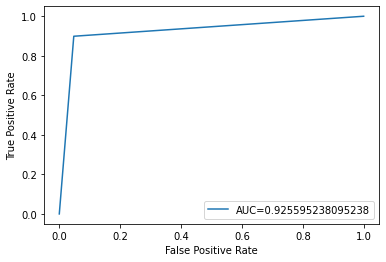

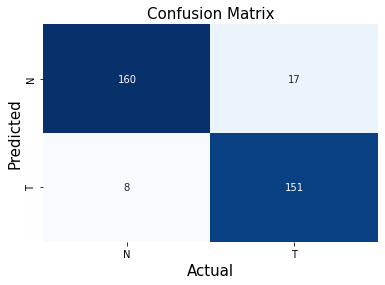

End of epoch  3 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 129s 891ms/step - loss: 2.6022 - accuracy: 0.5648 - val_loss: 0.8922 - val_accuracy: 0.7093
Epoch 2/100
145/145 [==============================] - 129s 890ms/step - loss: 0.7081 - accuracy: 0.7688 - val_loss: 0.6976 - val_accuracy: 0.8179
Epoch 3/100
145/145 [==============================] - 129s 891ms/step - loss: 0.5445 - accuracy: 0.8396 - val_loss: 0.6182 - val_accuracy: 0.8439
Epoch 4/100
145/145 [==============================] - 130s 894ms/step - loss: 0.4771 - accuracy: 0.8658 - val_loss: 0.5836 - val_accuracy: 0.8694
Epoch 5/100
145/145 [==============================] - 130s 895ms/step - loss: 0.4346 - accuracy: 0.8795 - val_loss: 0.5277 - val_accuracy: 0.8659
Epoch 6/100
145/145 [==============================] - 129s 889ms/step - loss: 0.4072 - accuracy: 0.8871 - val_loss: 0.5

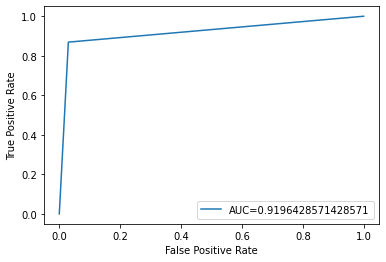

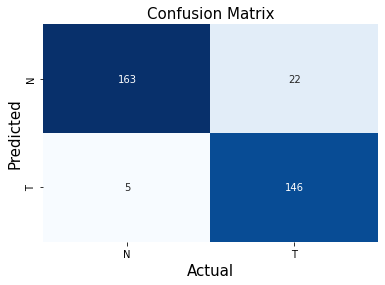

End of epoch  4 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 130s 892ms/step - loss: 2.6314 - accuracy: 0.5306 - val_loss: 0.9626 - val_accuracy: 0.6535
Epoch 2/100
145/145 [==============================] - 130s 892ms/step - loss: 0.7852 - accuracy: 0.7284 - val_loss: 0.7083 - val_accuracy: 0.8222
Epoch 3/100
145/145 [==============================] - 130s 893ms/step - loss: 0.5801 - accuracy: 0.8164 - val_loss: 0.5828 - val_accuracy: 0.8625
Epoch 4/100
145/145 [==============================] - 129s 891ms/step - loss: 0.5049 - accuracy: 0.8489 - val_loss: 0.5538 - val_accuracy: 0.8763
Epoch 5/100
145/145 [==============================] - 130s 893ms/step - loss: 0.4620 - accuracy: 0.8640 - val_loss: 0.5176 - val_accuracy: 0.8849
Epoch 6/100
145/145 [==============================] - 130s 898ms/step - loss: 0.4404 - accuracy: 0.8686 - val_loss: 0.4

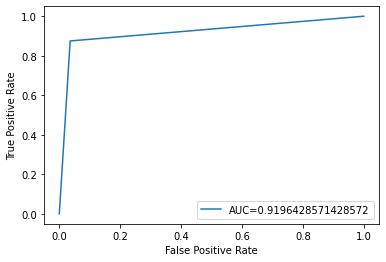

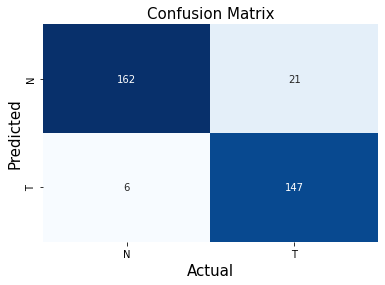

End of epoch  5 




 

Coefficient of Variation of accuracy : 0.0001065403522797949
Coefficient of Variation of loss : 0.003104850073276188
Average test accuracy : 0.92
Average test loss : 0.36


In [ ]:
# model of base cnn

validation_accuracy_cnn = []
validation_loss_cnn = []
epoch_n = 0

for train_idx, val_idx in list(skfold.split(train_x,train_y)):
    
    x_train_df = df.iloc[train_idx]  
    x_valid_df   = df.iloc[val_idx]

    x_train_df = x_train_df.sample(frac=1).reset_index(drop=True)
    x_valid_df = x_valid_df.sample(frac=1).reset_index(drop=True)

    training_set = train_datagen.flow_from_dataframe(dataframe = x_train_df,
                                                  x_col="image", 
                                                  y_col="type",
                                                  target_size= (IMAGE_H,IMAGE_L),
                                                  batch_size = 64,
                                                  color_mode= "grayscale", 
                                                  class_mode= 'categorical',
                                                  shuffle = True)
    

    validation_set = validation_datagen.flow_from_dataframe(dataframe = x_valid_df,
                                                 x_col="image",
                                                 y_col="type",
                                                 target_size= (IMAGE_H,IMAGE_L),
                                                 batch_size = 64,
                                                 color_mode= "grayscale",
                                                 class_mode= 'categorical',
                                                 shuffle = False)

    cnn = get_model_cnn(classes = CLASSES, input_shape=(IMAGE_H, IMAGE_L, CHANNEL))

    history = cnn.fit(training_set, epochs=EPOCHS, validation_data = validation_set, callbacks=[earlystopping], class_weight=class_weights)

    # table of validation accuracy and loss
    loss, acc = cnn.evaluate(test_set)
    validation_accuracy_cnn.append(acc)
    validation_loss_cnn.append(loss)

    predict = cnn.predict(test_set)
    y_pred = np.argmax(predict, axis=1)
    true_classes = test_set.classes
    class_labels = list(test_set.class_indices.keys())

    report = classification_report(true_classes,  y_pred, target_names=class_labels)
    print(report)

    # roc curve
    fpr, tpr, _ = metrics.roc_curve(true_classes,  y_pred)
    auc = metrics.roc_auc_score(true_classes, y_pred)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # confusion matrix
    #print("\n\n", predict)
    #print(y_pred)
    #print(true_classes, "\n\n")
    cf_matrix = (confusion_matrix(true_classes, y_pred))
    cf_matrix = np.transpose(cf_matrix)
    plt.figure()
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['N','T'], yticklabels=['N','T'])
    plt.title('Confusion Matrix', fontsize = 15)
    plt.xlabel('Actual', fontsize = 15)
    plt.ylabel('Predicted', fontsize = 15)
    plt.show()
    
    epoch_n+=1
    print("End of epoch ", epoch_n, "\n\n\n\n\n ")
    K.clear_session()

print("\nCoefficient of Variation of accuracy :", np.var(validation_accuracy_cnn)/np.mean(validation_accuracy_cnn))
print("Coefficient of Variation of loss :", np.var(validation_loss_cnn)/np.mean(validation_loss_cnn))
print("Average test accuracy :", round(np.mean(validation_accuracy_cnn),2))
print("Average test loss :", round(np.mean(validation_loss_cnn),2))

In [ ]:
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 223, 223, 64)      320       
                                                                 
 activation (Activation)     (None, 223, 223, 64)      0         
                                                                 
 dropout (Dropout)           (None, 223, 223, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 110, 110, 128)     32896     
                                                               

### **ResNet**

re-initialize constants for ResNet

In [ ]:
EPOCHS = 100
IMAGE_H = 224 
IMAGE_L = 224
CHANNEL = 1
CLASSES = 2 # normal and tilted

In [ ]:
# opt = gradient_descent_v2.SGD(learning_rate=0.001, momentum=0.9, decay=0.001/EPOCHS)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.1) # 0.001 # 0.084935

In [ ]:
def decay(epoch, steps=100):
    initial_lrate = 0.0001
    drop = 0.96
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
# ResNet-50 functions

def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    #X = Dropout(0.2)(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    #X = Dropout(0.2)(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def get_model_ResNet(classes, input_shape =()):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(1024, activation='relu', kernel_regularizer = regularizers.l2(0.01))(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='tanh', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    model.compile(optimizer=opt, loss='squared_hinge', metrics=['accuracy'], run_eagerly=True)

    return model

callbacks utilities

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", patience = 5, restore_best_weights = True)

lr_sc = LearningRateScheduler(decay, verbose=1)

In [ ]:
ResNet.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  3200        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

Found 9249 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 116s 798ms/step - loss: 6.2592 - accuracy: 0.5218 - val_loss: 2.6133 - val_accuracy: 0.5214
Epoch 2/100
145/145 [==============================] - 115s 794ms/step - loss: 2.3349 - accuracy: 0.5214 - val_loss: 2.0538 - val_accuracy: 0.5214
Epoch 3/100
145/145 [==============================] - 116s 796ms/step - loss: 2.0815 - accuracy: 0.5162 - val_loss: 2.0880 - val_accuracy: 0.4786
Epoch 4/100
145/145 [==============================] - 115s 794ms/step - loss: 2.0391 - accuracy: 0.4792 - val_loss: 2.1841 - val_accuracy: 0.4786
Epoch 5/100
145/145 [==============================] - 116s 797ms/step - loss: 1.7683 - accuracy: 0.5156 - val_loss: 1.9767 - val_accuracy: 0.5201
Epoch 6/100
145/145 [==============================] - 115s 794ms/step - loss: 1.0378 - accuracy: 0.6510 - val_loss: 0.9651 - val_accuracy: 0.6

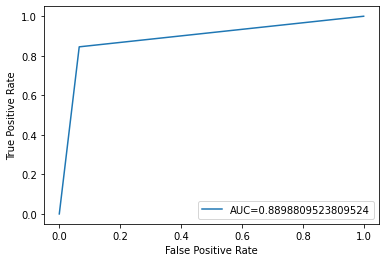

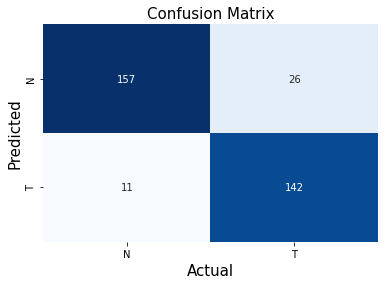

End of epoch  1 




 
Found 9249 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 113s 774ms/step - loss: 6.4456 - accuracy: 0.4780 - val_loss: 2.7187 - val_accuracy: 0.4786
Epoch 2/100
145/145 [==============================] - 112s 774ms/step - loss: 2.3629 - accuracy: 0.4786 - val_loss: 2.1508 - val_accuracy: 0.4786
Epoch 3/100
145/145 [==============================] - 115s 791ms/step - loss: 2.0743 - accuracy: 0.4786 - val_loss: 2.0495 - val_accuracy: 0.4786
Epoch 4/100
145/145 [==============================] - 114s 783ms/step - loss: 2.0385 - accuracy: 0.4786 - val_loss: 2.0339 - val_accuracy: 0.4786
Epoch 5/100
145/145 [==============================] - 111s 768ms/step - loss: 1.8463 - accuracy: 0.4925 - val_loss: 1.3658 - val_accuracy: 0.5058
Epoch 6/100
145/145 [==============================] - 112s 773ms/step - loss: 1.0466 - accuracy: 0.6155 - val_loss: 1.1

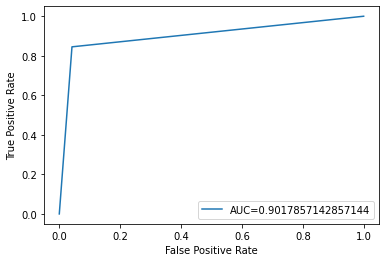

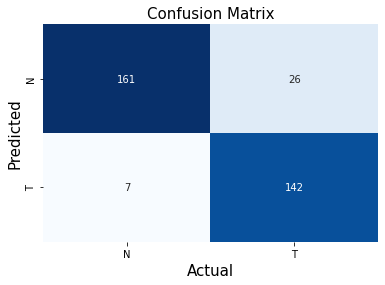

End of epoch  2 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 113s 775ms/step - loss: 5.9371 - accuracy: 0.4781 - val_loss: 2.4901 - val_accuracy: 0.4788
Epoch 2/100
145/145 [==============================] - 112s 768ms/step - loss: 2.2429 - accuracy: 0.4779 - val_loss: 2.1345 - val_accuracy: 0.4788
Epoch 3/100
145/145 [==============================] - 112s 769ms/step - loss: 2.0599 - accuracy: 0.4786 - val_loss: 2.0232 - val_accuracy: 0.4788
Epoch 4/100
145/145 [==============================] - 112s 771ms/step - loss: 2.0487 - accuracy: 0.4786 - val_loss: 2.1050 - val_accuracy: 0.4788
Epoch 5/100
145/145 [==============================] - 111s 768ms/step - loss: 2.0144 - accuracy: 0.4786 - val_loss: 1.9907 - val_accuracy: 0.4788
Epoch 6/100
145/145 [==============================] - 112s 770ms/step - loss: 1.9071 - accuracy: 0.5039 - val_loss: 1.8

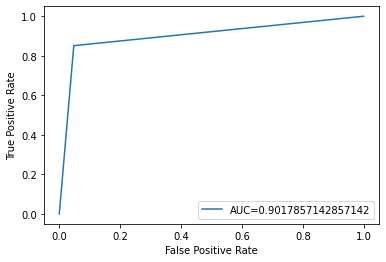

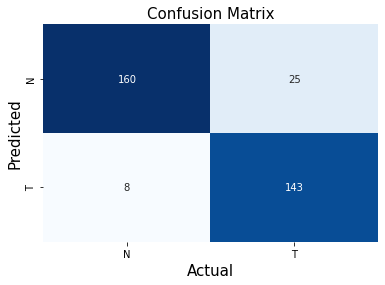

End of epoch  3 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 112s 771ms/step - loss: 6.9159 - accuracy: 0.4782 - val_loss: 2.9088 - val_accuracy: 0.4788
Epoch 2/100
145/145 [==============================] - 111s 767ms/step - loss: 2.4042 - accuracy: 0.4760 - val_loss: 2.2949 - val_accuracy: 0.4788
Epoch 3/100
145/145 [==============================] - 112s 771ms/step - loss: 2.1390 - accuracy: 0.4996 - val_loss: 2.1339 - val_accuracy: 0.4788
Epoch 4/100
145/145 [==============================] - 111s 768ms/step - loss: 1.8828 - accuracy: 0.5525 - val_loss: 1.8309 - val_accuracy: 0.4978
Epoch 5/100
145/145 [==============================] - 112s 771ms/step - loss: 1.1108 - accuracy: 0.6498 - val_loss: 1.0342 - val_accuracy: 0.6622
Epoch 6/100
145/145 [==============================] - 112s 772ms/step - loss: 0.8160 - accuracy: 0.7448 - val_loss: 1.0

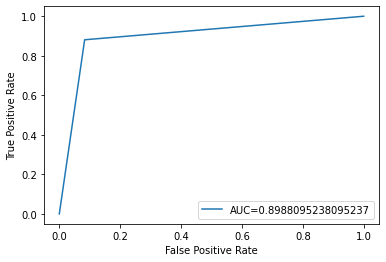

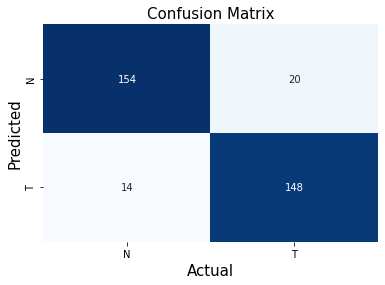

End of epoch  4 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 113s 775ms/step - loss: 6.1297 - accuracy: 0.4785 - val_loss: 2.7638 - val_accuracy: 0.4784
Epoch 2/100
145/145 [==============================] - 112s 768ms/step - loss: 2.2842 - accuracy: 0.4787 - val_loss: 2.1799 - val_accuracy: 0.4784
Epoch 3/100
145/145 [==============================] - 112s 770ms/step - loss: 2.0759 - accuracy: 0.4775 - val_loss: 2.1026 - val_accuracy: 0.4784
Epoch 4/100
145/145 [==============================] - 112s 769ms/step - loss: 2.0454 - accuracy: 0.4779 - val_loss: 2.0142 - val_accuracy: 0.4784
Epoch 5/100
145/145 [==============================] - 112s 769ms/step - loss: 1.6143 - accuracy: 0.5249 - val_loss: 1.3891 - val_accuracy: 0.5108
Epoch 6/100
145/145 [==============================] - 111s 766ms/step - loss: 0.9863 - accuracy: 0.6631 - val_loss: 1.4

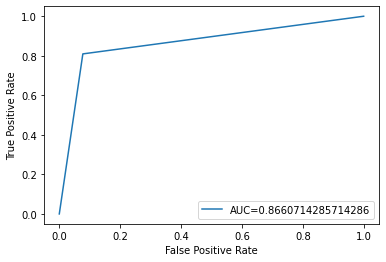

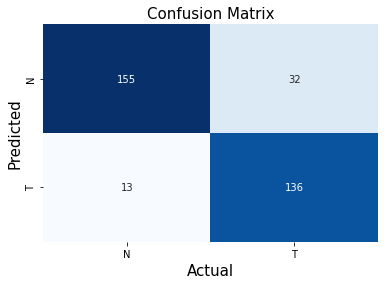

End of epoch  5 




 

Coefficient of Variation of accuracy : 0.00020503581990462255
Coefficient of Variation of loss : 0.0032786024926041647
Average test accuracy : 0.89
Average test loss : 0.36


In [ ]:
# model of ResNet

validation_accuracy_ResNet = []
validation_loss_ResNet = []
epoch_n = 0

for train_idx, val_idx in list(skfold.split(train_x,train_y)):
    
    x_train_df = df.iloc[train_idx]  
    x_valid_df   = df.iloc[val_idx]

    x_train_df = x_train_df.sample(frac=1).reset_index(drop=True)
    x_valid_df = x_valid_df.sample(frac=1).reset_index(drop=True)

    training_set = train_datagen.flow_from_dataframe(dataframe = x_train_df,
                                                  x_col="image", 
                                                  y_col="type",
                                                  target_size= (IMAGE_H,IMAGE_L),
                                                  batch_size = 64,
                                                  color_mode= "grayscale", 
                                                  class_mode= 'categorical',
                                                  shuffle=True)
    
    validation_set = validation_datagen.flow_from_dataframe(dataframe = x_valid_df,
                                                 x_col="image", 
                                                 y_col="type",
                                                 target_size= (IMAGE_H,IMAGE_L),
                                                 batch_size = 64,
                                                 color_mode= "grayscale",
                                                 class_mode= 'categorical',
                                                 shuffle=False)
    
    ResNet = get_model_ResNet(classes = CLASSES, input_shape = (IMAGE_H, IMAGE_L, CHANNEL))

    history = ResNet.fit(training_set, epochs=EPOCHS, validation_data = validation_set, callbacks=[earlystopping], class_weight=class_weights)

    loss, acc = ResNet.evaluate(test_set)
    validation_accuracy_ResNet.append(acc)
    validation_loss_ResNet.append(loss)

    predict = ResNet.predict(test_set)
    y_pred = np.argmax(predict, axis=1)
    true_classes = test_set.classes
    #print("predict: ", predict)
    #print("y_pred: ",y_pred)
    #print("true classes: ", true_classes)
    class_labels = list(test_set.class_indices.keys())

    report = classification_report(true_classes,  y_pred, target_names=class_labels)
    print(report)

    # roc curve
    fpr, tpr, _ = metrics.roc_curve(true_classes,  y_pred)
    auc = metrics.roc_auc_score(true_classes, y_pred)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    #confussion matrix
    cf_matrix = (confusion_matrix(true_classes, y_pred))
    cf_matrix = np.transpose(cf_matrix)
    plt.figure()
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['N','T'], yticklabels=['N','T'])
    plt.title('Confusion Matrix', fontsize = 15)
    plt.xlabel('Actual', fontsize = 15)
    plt.ylabel('Predicted', fontsize = 15)
    plt.show()

    epoch_n+=1
    print("End of epoch ", epoch_n, "\n\n\n\n\n ")
    K.clear_session()

print("\nCoefficient of Variation of accuracy :", np.var(validation_accuracy_ResNet)/np.mean(validation_accuracy_ResNet))
print("Coefficient of Variation of loss :", np.var(validation_loss_ResNet)/np.mean(validation_loss_ResNet))
print("Average test accuracy :", round(np.mean(validation_accuracy_ResNet),2))
print("Average test loss :", round(np.mean(validation_loss_ResNet),2))

### **Inception Network**

re-initialize constants for Inception Network

In [ ]:
from keras.utils import np_utils

In [ ]:
EPOCHS = 100
IMAGE_H = 224
IMAGE_L = 224
CHANNEL = 1
CLASSES = 2 # normal and tilted

In [ ]:
# opt = gradient_descent_v2.SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9) # 0.084935
opt = tf.keras.optimizers.Adam(learning_rate=0.001) # adam optimizer is not working for inception network

In [ ]:
def list_dirtoRGB(dir_list):
  RGB_list = []
  for i in dir_list:
    img_rgb = cv2.imread(i)
    RGB_list.append(img_rgb)

  return RGB_list

def hot_labeling(string_list):
  hot_labeledlist = []
  no_labels = len(string_list.unique())
    
  number_list = []
  for i in range(no_labels):
    number_list.append(i)

  type_list = [] # 0. normal , 1. tilted
  for i in string_list.unique():
    type_list.append(i)

  for i in string_list:
    if i == type_list[0]: # normal
      hot_labeledlist.append([number_list[0]])
    else:
      hot_labeledlist.append([number_list[1]])

  return hot_labeledlist

def decay(epoch, steps=100):
    initial_lrate = 0.001
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
# Inception Architecture functions

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=glorot_uniform())(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=glorot_uniform())(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=glorot_uniform())(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=glorot_uniform())(x) 
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=glorot_uniform())(conv_5x5) 

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=glorot_uniform())(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

def get_model_inceptionNet(classes, input_shape=()):

  X_input = Input(input_shape)
  x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=glorot_uniform())(X_input)
  x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
  x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
  x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
  x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
  x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_3a')
  x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_3b')
  x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
  x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64, name='inception_4a')
  x1 = AveragePooling2D((5, 5), strides=3)(x)
  x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(1024, activation='relu')(x1)
  x1 = Dropout(0.7)(x1)
  x1 = Dense(CLASSES, activation='softmax', name='output_ax1')(x1) # auxilliary_output_1

  x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4b')
  x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4c')
  x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64, name='inception_4d')
  x2 = AveragePooling2D((5, 5), strides=3)(x)
  x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
  x2 = Flatten()(x2)
  x2 = Dense(1024, activation='relu')(x2)
  x2 = Dropout(0.7)(x2)
  x2 = Dense(CLASSES, activation='softmax', name='output_ax2')(x2) # auxilliary_output_2

  x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_4e')
  x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
  x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_5a')
  x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128, name='inception_5b')
  x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
  x = Dropout(0.4)(x)
  x = Dense(CLASSES, activation='tanh', name='output')(x)

  model = Model(X_input, [x, x1, x2], name='inception_v1')

  model.compile(loss=['squared_hinge', 'squared_hinge', 'squared_hinge'], loss_weights=[1, 0.3, 0.3], optimizer=opt, metrics=['accuracy']) #, run_eagerly=True)
  #categorical_crossentropy

  return model

callbacks utilities

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", patience = 10, restore_best_weights = True)

lr_sc = LearningRateScheduler(decay, verbose=1)

Found 9249 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 115s 760ms/step - loss: 1.7502 - output_loss: 1.0004 - output_ax1_loss: 1.2492 - output_ax2_loss: 1.2500 - output_accuracy: 0.4957 - output_ax1_accuracy: 0.5118 - output_ax2_accuracy: 0.4999 - val_loss: 1.7456 - val_output_loss: 0.9979 - val_output_ax1_loss: 1.2443 - val_output_ax2_loss: 1.2479 - val_output_accuracy: 0.5214 - val_output_ax1_accuracy: 0.5214 - val_output_ax2_accuracy: 0.5214
Epoch 2/100
145/145 [==============================] - 112s 770ms/step - loss: 1.7254 - output_loss: 0.9885 - output_ax1_loss: 1.2264 - output_ax2_loss: 1.2299 - output_accuracy: 0.5491 - output_ax1_accuracy: 0.5796 - output_ax2_accuracy: 0.5648 - val_loss: 1.6791 - val_output_loss: 0.9652 - val_output_ax1_loss: 1.1839 - val_output_ax2_loss: 1.1959 - val_output_accuracy: 0.5837 - val_output_ax1_accuracy: 0.6217 - val_output_a

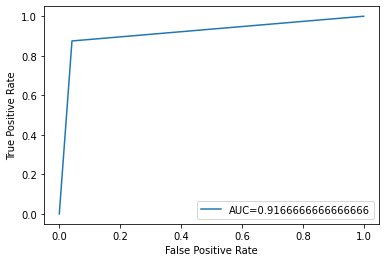

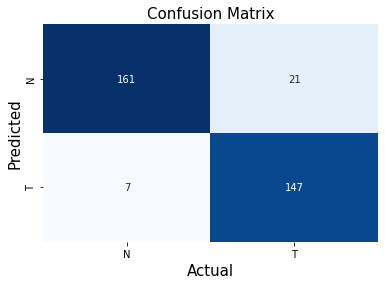

End of epoch  1 




 
Found 9249 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 114s 762ms/step - loss: 1.7509 - output_loss: 1.0007 - output_ax1_loss: 1.2505 - output_ax2_loss: 1.2502 - output_accuracy: 0.4999 - output_ax1_accuracy: 0.4996 - output_ax2_accuracy: 0.5021 - val_loss: 1.7501 - val_output_loss: 0.9999 - val_output_ax1_loss: 1.2506 - val_output_ax2_loss: 1.2501 - val_output_accuracy: 0.5214 - val_output_ax1_accuracy: 0.4786 - val_output_ax2_accuracy: 0.4786
Epoch 2/100
145/145 [==============================] - 110s 757ms/step - loss: 1.7506 - output_loss: 1.0015 - output_ax1_loss: 1.2463 - output_ax2_loss: 1.2508 - output_accuracy: 0.4834 - output_ax1_accuracy: 0.5102 - output_ax2_accuracy: 0.4921 - val_loss: 1.7497 - val_output_loss: 1.0003 - val_output_ax1_loss: 1.2474 - val_output_ax2_loss: 1.2503 - val_output_accuracy: 0.4786 - val_output_ax1_accuracy

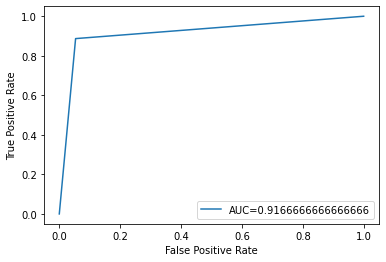

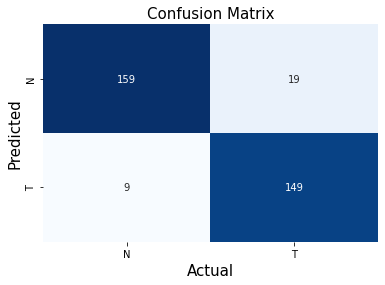

End of epoch  2 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 114s 765ms/step - loss: 1.7510 - output_loss: 1.0009 - output_ax1_loss: 1.2499 - output_ax2_loss: 1.2505 - output_accuracy: 0.4965 - output_ax1_accuracy: 0.5045 - output_ax2_accuracy: 0.5002 - val_loss: 1.7510 - val_output_loss: 1.0004 - val_output_ax1_loss: 1.2522 - val_output_ax2_loss: 1.2501 - val_output_accuracy: 0.4788 - val_output_ax1_accuracy: 0.4788 - val_output_ax2_accuracy: 0.4788
Epoch 2/100
145/145 [==============================] - 111s 762ms/step - loss: 1.7453 - output_loss: 1.0000 - output_ax1_loss: 1.2361 - output_ax2_loss: 1.2481 - output_accuracy: 0.5055 - output_ax1_accuracy: 0.5411 - output_ax2_accuracy: 0.5173 - val_loss: 1.7251 - val_output_loss: 0.9947 - val_output_ax1_loss: 1.1984 - val_output_ax2_loss: 1.2361 - val_output_accuracy: 0.5597 - val_output_ax1_accuracy

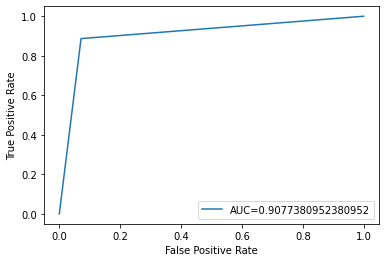

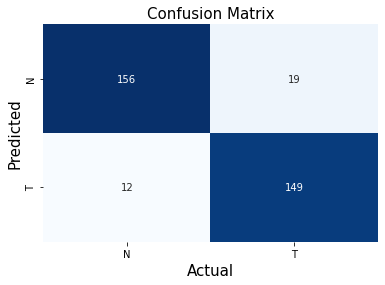

End of epoch  3 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 115s 762ms/step - loss: 1.7480 - output_loss: 0.9999 - output_ax1_loss: 1.2449 - output_ax2_loss: 1.2487 - output_accuracy: 0.5121 - output_ax1_accuracy: 0.5318 - output_ax2_accuracy: 0.5123 - val_loss: 1.7085 - val_output_loss: 0.9862 - val_output_ax1_loss: 1.1870 - val_output_ax2_loss: 1.2207 - val_output_accuracy: 0.5874 - val_output_ax1_accuracy: 0.6298 - val_output_ax2_accuracy: 0.5943
Epoch 2/100
145/145 [==============================] - 110s 758ms/step - loss: 1.6464 - output_loss: 0.9500 - output_ax1_loss: 1.1460 - output_ax2_loss: 1.1755 - output_accuracy: 0.5787 - output_ax1_accuracy: 0.6395 - output_ax2_accuracy: 0.6135 - val_loss: 1.4335 - val_output_loss: 0.7931 - val_output_ax1_loss: 1.0830 - val_output_ax2_loss: 1.0518 - val_output_accuracy: 0.6925 - val_output_ax1_accuracy

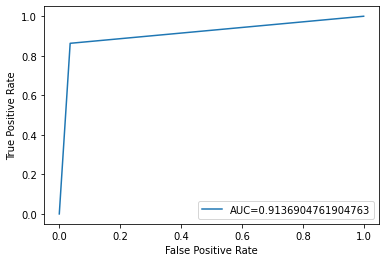

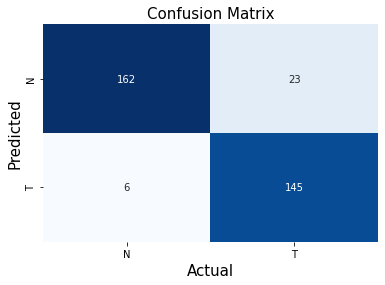

End of epoch  4 




 
Found 9250 validated image filenames belonging to 2 classes.
Found 2312 validated image filenames belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 115s 766ms/step - loss: 1.7515 - output_loss: 1.0010 - output_ax1_loss: 1.2509 - output_ax2_loss: 1.2506 - output_accuracy: 0.4898 - output_ax1_accuracy: 0.5016 - output_ax2_accuracy: 0.4836 - val_loss: 1.7492 - val_output_loss: 0.9995 - val_output_ax1_loss: 1.2489 - val_output_ax2_loss: 1.2500 - val_output_accuracy: 0.5216 - val_output_ax1_accuracy: 0.5216 - val_output_ax2_accuracy: 0.5216
Epoch 2/100
145/145 [==============================] - 109s 749ms/step - loss: 1.7287 - output_loss: 0.9915 - output_ax1_loss: 1.2245 - output_ax2_loss: 1.2329 - output_accuracy: 0.5378 - output_ax1_accuracy: 0.5746 - output_ax2_accuracy: 0.5492 - val_loss: 1.6848 - val_output_loss: 0.9773 - val_output_ax1_loss: 1.1742 - val_output_ax2_loss: 1.1844 - val_output_accuracy: 0.5926 - val_output_ax1_accuracy

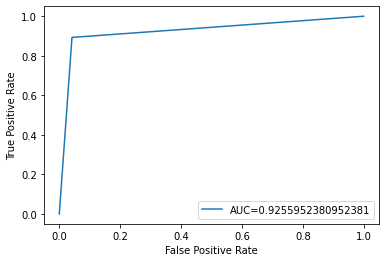

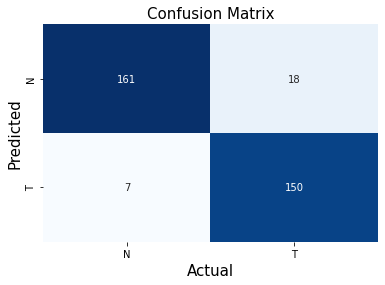

End of epoch  5 




 

Coefficient of Variation of accuracy : 3.635632444942167e-05
Coefficient of Variation of loss : 0.00018800601950887656
Average test accuracy : 0.92
Average test loss : 0.29


In [ ]:
# model of Inception Network

validation_accuracy_inceptionNet = []
validation_loss_inceptionNet = []
epoch_n = 0

for train_idx, val_idx in list(skfold.split(train_x,train_y)):
    
    x_train_df = df.iloc[train_idx]  # dataframe for training ; contain both image and it's label
    x_valid_df   = df.iloc[val_idx]  # dataframe for validation ; contain both image and it's label
    
    x_train_df = x_train_df.sample(frac=1).reset_index(drop=True)
    x_valid_df = x_valid_df.sample(frac=1).reset_index(drop=True)

    #X_train = np.array([cv2.imread(i) for i in x_train_df['image']])
    #X_train = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in X_train])
    #X_train = np.array([cv2.resize(img, (IMAGE_H,IMAGE_L)) for img in X_train])
    #X_train = X_train.astype('float32')
    #X_train = X_train / 255.0
    #y_train = hot_labeling(x_train_df['type'])
    #y_train = keras.utils.np_utils.to_categorical(y_train, CLASSES)
    
    #X_valid = np.array([cv2.imread(i) for i in x_valid_df['image']])
    #X_valid = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in X_valid])
    #X_valid = np.array([cv2.resize(img, (IMAGE_H,IMAGE_L)) for img in X_valid])
    #X_valid = X_valid.astype('float32')
    #X_valid = X_valid / 255.0
    #y_valid = hot_labeling(x_valid_df['type'])
    #y_valid = keras.utils.np_utils.to_categorical(y_valid, CLASSES)

    training_set = train_datagen.flow_from_dataframe(dataframe = x_train_df,
                                                  x_col="image", 
                                                  y_col="type",
                                                  target_size= (IMAGE_H,IMAGE_L),
                                                  batch_size = 64,
                                                  color_mode= "grayscale", 
                                                  class_mode= 'categorical',
                                                  shuffle=True)
    
    validation_set = validation_datagen.flow_from_dataframe(dataframe = x_valid_df,
                                                 x_col="image", 
                                                 y_col="type",
                                                 target_size= (IMAGE_H,IMAGE_L),
                                                 batch_size = 64,
                                                 color_mode= "grayscale",
                                                 class_mode= 'categorical',
                                                 shuffle=False)

    inceptionNet = get_model_inceptionNet(classes = CLASSES, input_shape = (IMAGE_H, IMAGE_L, CHANNEL))

    history = inceptionNet.fit(training_set, validation_data=validation_set, epochs=EPOCHS, callbacks=[earlystopping], class_weight=class_weights)
    #history = inceptionNet.fit(X_train, [y_train, y_train, y_train], validation_data=(X_valid, [y_valid, y_valid, y_valid]), epochs=EPOCHS, callbacks=[lr_sc]) #, batch_size=64)

    output_list = inceptionNet.evaluate(test_set)
    loss = output_list[1]
    acc = output_list[4]
    validation_accuracy_inceptionNet.append(acc)
    validation_loss_inceptionNet.append(loss)

    predict_list = inceptionNet.predict(test_set)
    predict = predict_list[0]
    y_pred = np.argmax(predict, axis=1)
    true_classes = test_set.classes
    class_labels = list(test_set.class_indices.keys())

    report = classification_report(true_classes,  y_pred, target_names=class_labels)
    print(report)
    #print("\n\n", predict)
    #print(y_pred)
    #print(true_classes, "\n\n")
    #class_labels = list(test_set.class_indices.keys())

    # roc curve
    fpr, tpr, _ = metrics.roc_curve(true_classes,  y_pred)
    auc = metrics.roc_auc_score(true_classes, y_pred)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # confusion matrix
    cf_matrix = (confusion_matrix(true_classes, y_pred))
    cf_matrix = np.transpose(cf_matrix)
    plt.figure()
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['N','T'], yticklabels=['N','T'])
    plt.title('Confusion Matrix', fontsize = 15)
    plt.xlabel('Actual', fontsize = 15)
    plt.ylabel('Predicted', fontsize = 15)
    plt.show()

    epoch_n+=1
    print("End of epoch ", epoch_n, "\n\n\n\n\n ")
    K.clear_session()

print("\nCoefficient of Variation of accuracy :", np.var(validation_accuracy_inceptionNet)/np.mean(validation_accuracy_inceptionNet))
print("Coefficient of Variation of loss :", np.var(validation_loss_inceptionNet)/np.mean(validation_loss_inceptionNet))
print("Average test accuracy :", round(np.mean(validation_accuracy_inceptionNet),2))
print("Average test loss :", round(np.mean(validation_loss_inceptionNet),2))

In [ ]:
inceptionNet.summary() 

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     